In [23]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from scipy.signal import find_peaks
from scipy.optimize import curve_fit



# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

import warnings
warnings.filterwarnings('ignore')

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [3]:
index = 1

obs = {
    'Teff' : [uni.loc[0, 'Teff'], uni.loc[0, 'e_Teff']],
    'logg' : [uni.loc[0, 'logg'], uni.loc[0, 'e_logg']],
    'MG' : [uni.loc[0, 'MGna'], uni.loc[0, 'e_MGna']],
    'bp_rp' : [uni.loc[0, 'bp_rp'], uni.loc[0, 'e_bp_rp']]
}

obs['logT'] = [0., 0.]
obs['logT'][0] = np.log10(obs['Teff'][0])
obs['logT'][1] = obs['Teff'][1] / (np.log(10)*obs['Teff'][0])

obs['logbp_rp'] = [0., 0.]
obs['logbp_rp'][0] = np.log10(obs['bp_rp'][0])
obs['logbp_rp'][1] = obs['bp_rp'][1] / (np.log(10)*obs['bp_rp'][0])

# Assume 10% uncertainty in absence of errors
for col in ['Teff','logg','MG','bp_rp']:
    if not np.isfinite(obs[col][1]):
        obs[col][1] = 0.1*obs[col][0]
        
    if not np.isfinite(obs[col][0]):
        obs = None
        use_prior = False
        print('Not enough information to use the prior until we allow for it.')
        break

In [4]:
j = janet.boot(uni, index=index, use_prior=True, obs=obs)

Already have data downloaded for Gaia ID 2174289161681454720.
If you want to check for new data, run `janet.update()`.
KDE built on 9029 values.


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 64.16it/s]

Done sampling prior!
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 17 on star 2174289161681454720 ###



/Users/Anaconda/anaconda3/envs/michael/lib/python3.8/site-packages/jazz_hands-0.0.3-py3.8.egg/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/75 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector 17 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 17 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 17 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation on star 2174289161681454720 ###


/Users/Anaconda/anaconda3/envs/michael/lib/python3.8/site-packages/astropy-4.3.1-py3.8-macosx-10.9-x86_64.egg/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



------ Decoding Overall Period Flag 36 ------
32: The ACF period does not match the 'best' period within 2 sigma.
4: Best rotation is from the Composite Autocorrelation Function (CACF) method.

No other flags raised. 



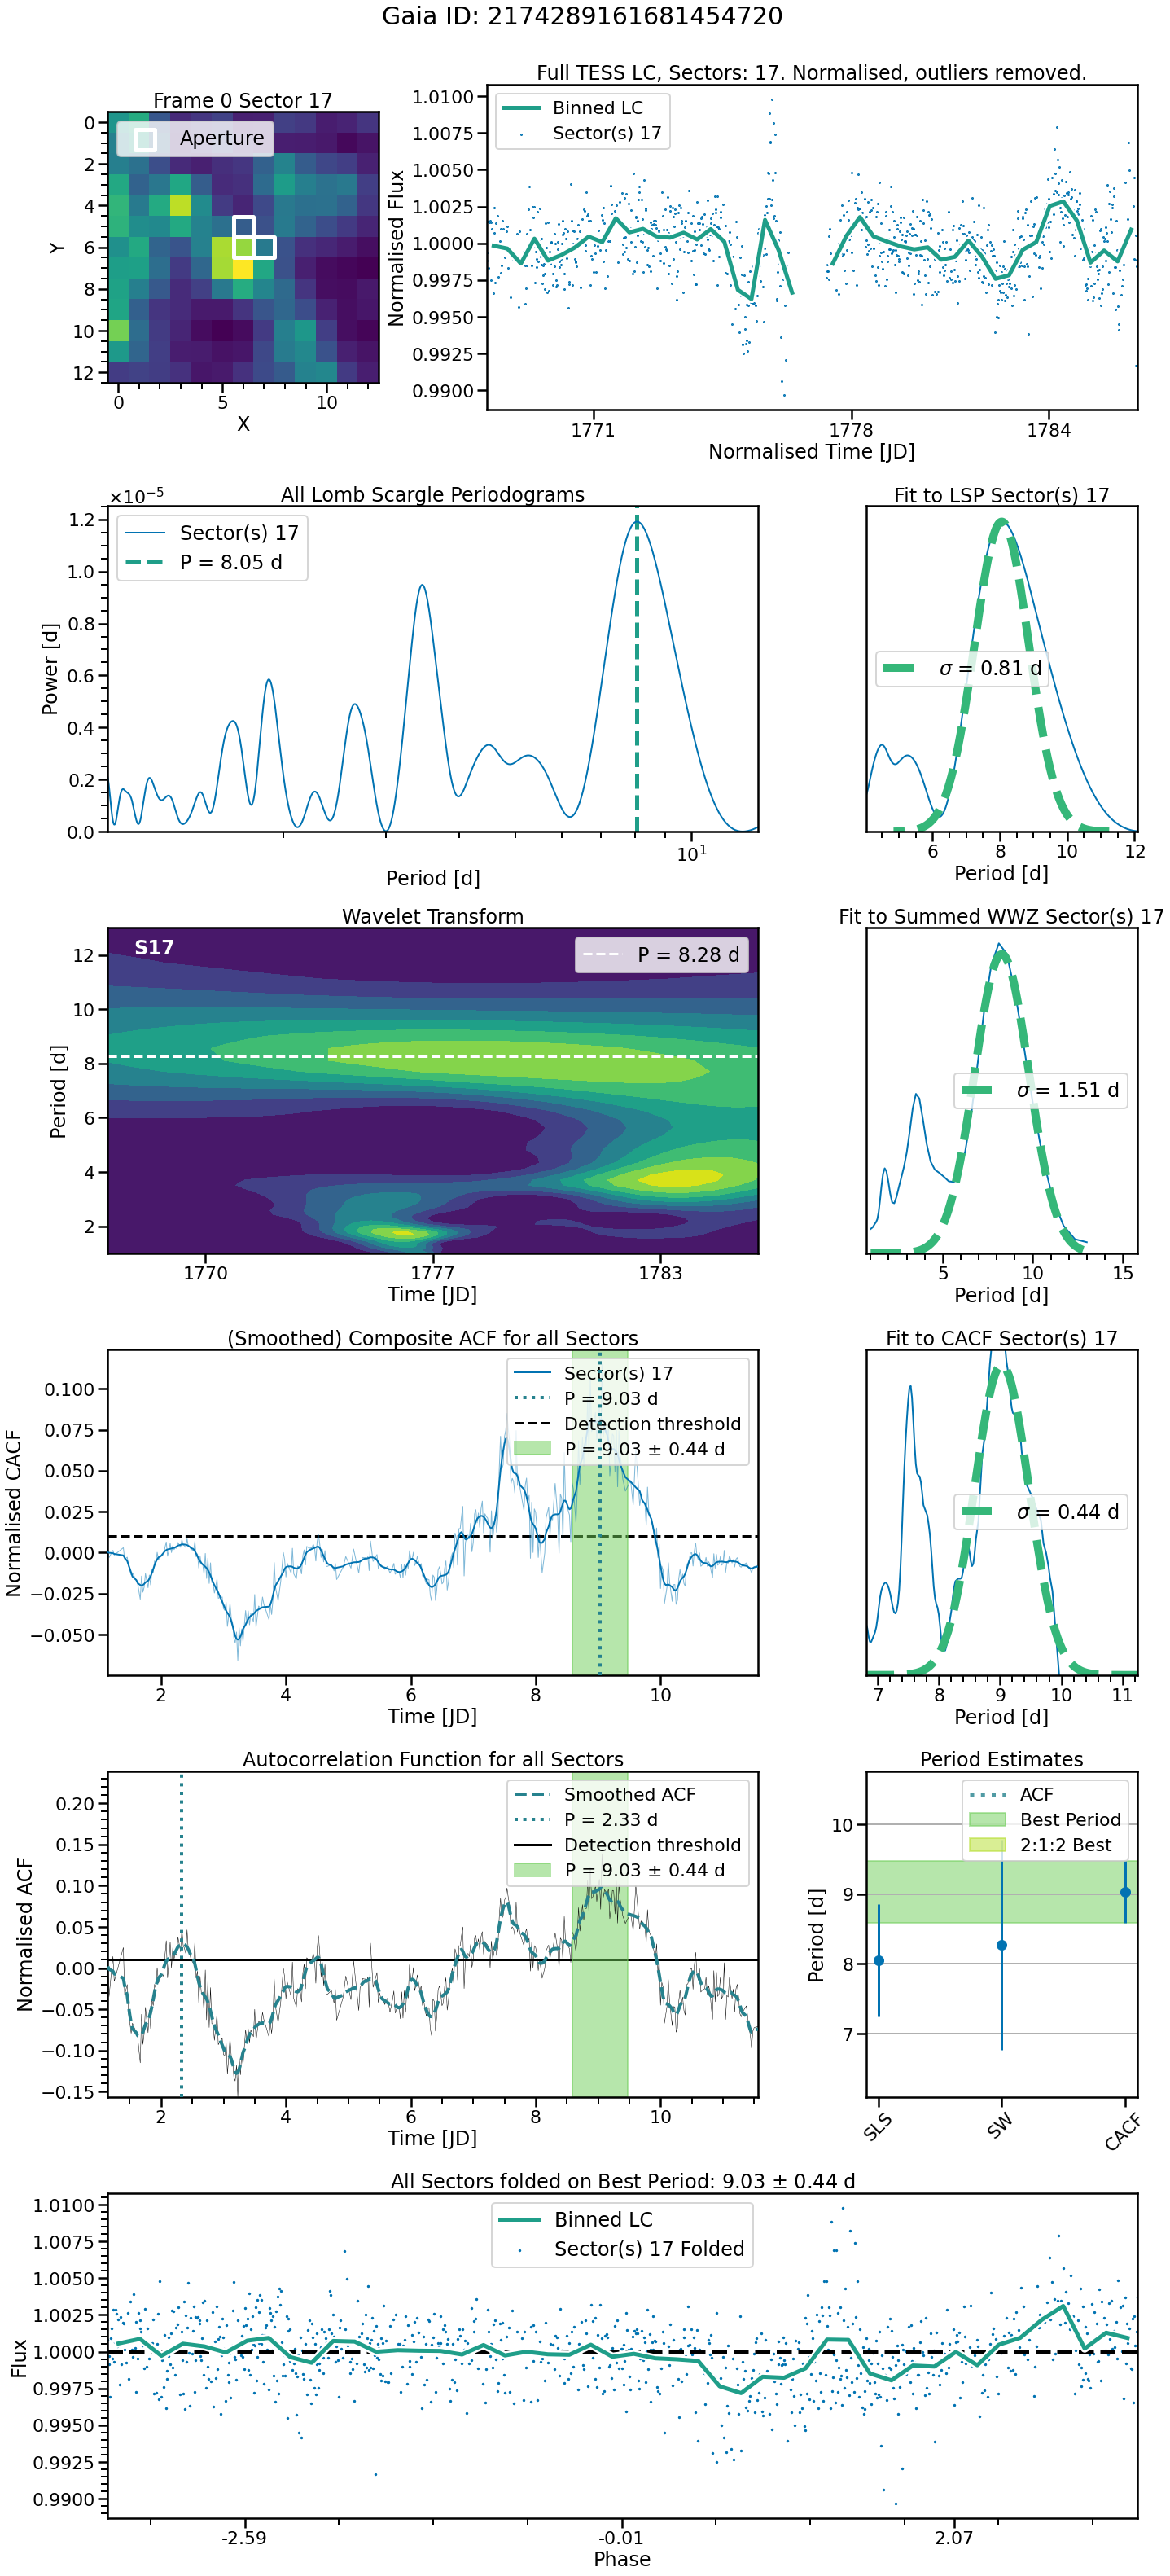

In [5]:
j.run(period_range = (1., 13.))

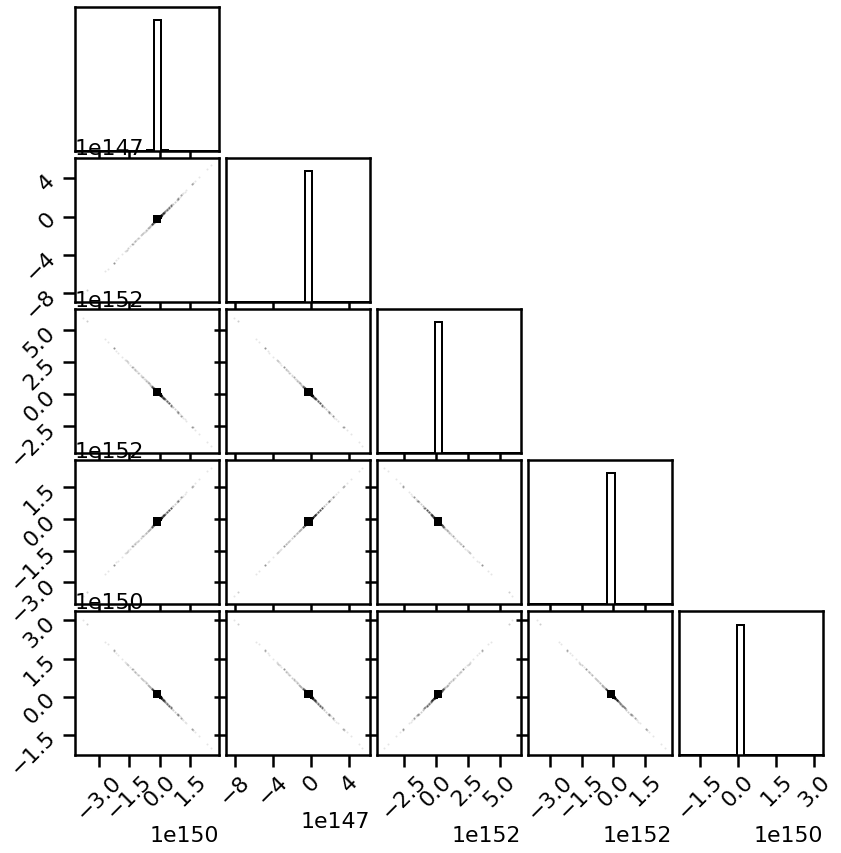

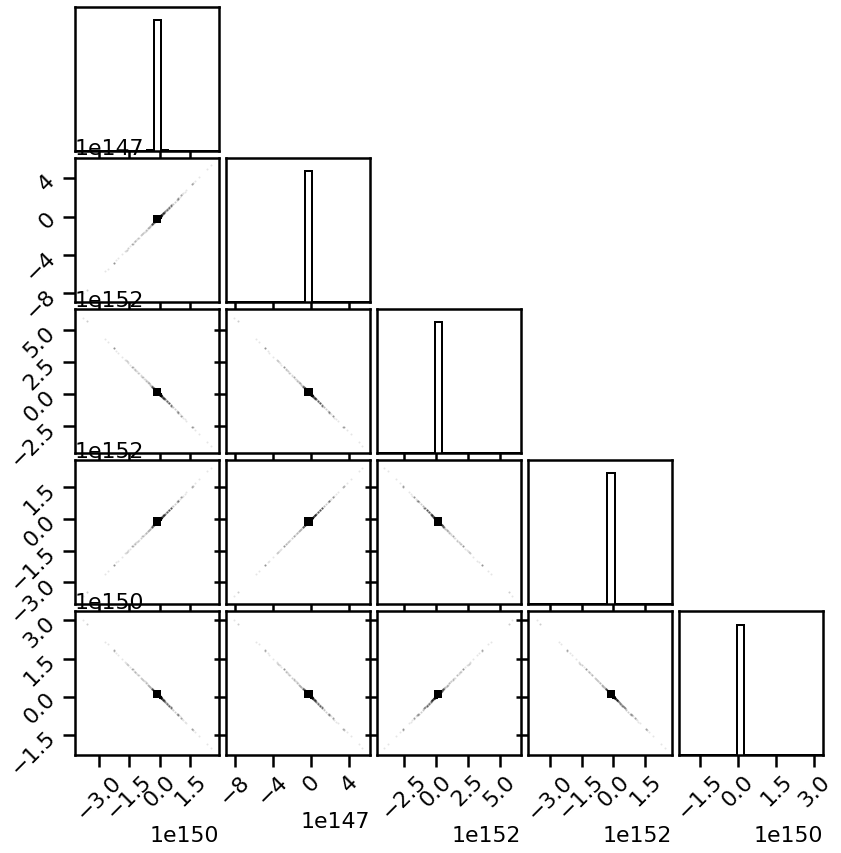

In [13]:
import corner

corner.corner(j.prior.samples)

In [14]:
np.nanpercentile(j.prior.samples[:,2], [16, 50, 84])

array([-2.87746180e+103,  1.12526743e+000,  6.59055703e+101])

In [15]:
nwalkers = 32
nsteps = 1000
ndim = 5
start =  [j.prior.obs['logT'][0],j.prior.obs['logg'][0], 1.3, j.prior.obs['MG'][0], j.prior.obs['logbp_rp'][0]]
p0 =  [start + np.random.rand(ndim) * [0.005, 0.001, 0.2, 0.2, 0.001] for n in range(nwalkers)]

In [16]:
p0[0]

array([3.78081355, 4.18208774, 1.30168455, 7.35614766, 0.19383211])

In [17]:
j.prior.likelihood(p0[1])

-68.59221877561204

In [18]:
j.prior.prior_pdf(p0[0])

array(9.04201539e-66)

In [19]:
j.prior.train

,logT,logg,logP,MGna,logbp_rp
0,3.691347,4.467,1.675778,6.170404,0.104892
1,3.805059,3.902,0.597695,3.100483,-0.042230
2,3.729780,4.539,1.398808,5.456108,-0.009365
3,3.766227,4.585,1.197281,5.438489,0.017400
4,3.553640,4.860,1.627673,8.673157,0.322335
...,...,...,...,...,...
38005,3.796935,4.172,1.021603,3.610828,-0.135594
38006,3.819215,4.228,0.439333,3.262778,-0.217455
38007,3.767853,4.139,0.173186,3.534343,-0.166264
38008,3.792041,4.315,0.824776,4.276190,-0.067881


In [22]:
j.prior.prior_pdf(j.prior.samples[50])

array(7.8587061e-65)